In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

# Preprocessing

## Data

In [64]:
df = pd.read_csv('data/train.csv')
df.SalePrice = np.log(df.SalePrice)

In [65]:
df = df.drop(columns='Id')
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072541
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254863
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864462


## Deal with missing values

In [66]:
df.isnull().sum()[df.isnull().sum()>0] / len(df) * 100

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

### Removing features with too many missing values

In [67]:
cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
df = df.drop(columns=cols)
df.shape

(1460, 76)

### Removing rows with too little missing values

In [68]:
df = df.dropna(thresh=66) # 66 is min no. of non-nulls --> these rows have 11 missing values
df.shape

(1454, 76)

### Removing rows with very low missing values (Electrical)

In [69]:
df.dropna(subset=['Electrical'], inplace=True)
df.shape

(1453, 76)

### Fillna

In [70]:
df['MasVnrType'].fillna('None', inplace=True) # None for absense of Masonry veneer
df['MasVnrArea'].fillna(0, inplace=True)      # 0 for absense of Masonry veneer

In [71]:
# None for absense of Basement
bsmtCols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for c in bsmtCols:
       df[c].fillna('None', inplace=True)

In [72]:
# None for absense of Garage
garageCols = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']
for c in garageCols:
       df[c].fillna('None', inplace=True)

In [73]:
df['FireplaceQu'].fillna('None', inplace=True) # None for absense of Fireplace

We will operate under the assumption that the Lot Frontage is related to what neighborhood a house is in. So we may fill-in the missing Lot Frontage value(s) with the mean(s) of Lot Frontages for that plarticular neighborhood in which the house is in.

In [74]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].\
                     transform(lambda val: val.fillna(val.mean()))

In [75]:
df.isnull().sum()[df.isnull().sum()>0] / len(df) * 100

Series([], dtype: float64)

## Catagorical encoding

In [76]:
grading_cols_1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',\
                 'KitchenQual','FireplaceQu','GarageQual','GarageCond']
grading_cols_2 = ['BsmtExposure']
grading_cols_3 = ['BsmtFinType1','BsmtFinType2']
grading_cols_4 = ['GarageFinish']

In [77]:
for c in grading_cols_1:
    df[c] = df[c].map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

for c in grading_cols_2:
    df[c] = df[c].map({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})

for c in grading_cols_3:
    df[c] = df[c].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})

for c in grading_cols_4:
    df[c] = df[c].map({'None':0, 'Unf':1, 'RFn':2, 'Fin':3})

In [78]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df.shape

(1453, 76)

In [79]:
df = pd.get_dummies(df, drop_first=True)
df.shape

# df = df.select_dtypes(exclude=object)
# df

(1453, 312)

## Removing outliers

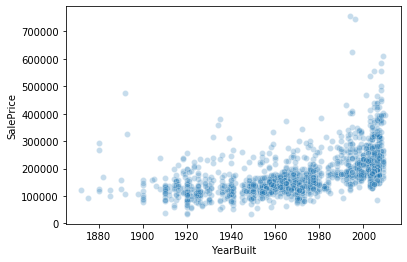

In [80]:
sns.scatterplot(x=df['YearBuilt'], y=np.exp(df['SalePrice']), alpha=0.25);

In [81]:
df.drop(df[df['SalePrice']>np.log(700000)].index, inplace=True)

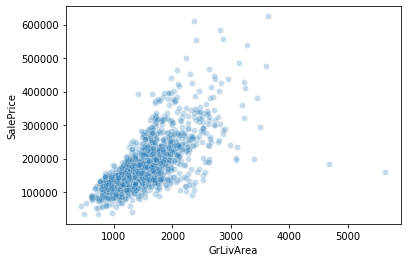

In [82]:
sns.scatterplot(x=df['GrLivArea'], y=np.exp(df['SalePrice']), alpha=0.25);

In [83]:
df.drop(df[df['GrLivArea']>4000].index, inplace=True)

In [84]:
df.shape

(1449, 312)

In [85]:
frac = 1

X = df.drop(columns='SalePrice').sample(frac=frac, random_state=42)
y = df['SalePrice'].sample(frac=frac, random_state=42)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((1159, 311), (290, 311))

# Feature Selection

In [48]:
# df_corr = df.corr()
# cols = df_corr.nlargest(14, 'SalePrice')['SalePrice'].index
# df = df[cols]
# df = df[cols].drop(['GarageYrBlt', 'GarageCars', '1stFlrSF', 'MasVnrArea'], axis=1)

In [86]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(n_estimators=100, n_jobs=-1) 
rfe = RFE(estimator, n_features_to_select=20)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_val_rfe = rfe.transform(X_val)

In [90]:
plt.figure(figsize=(50,5), dpi=100)
sns.barplot(x=X_train.columns, y=max(rfe.ranking_)-rfe.ranking_);

ValueError: Grouper and axis must be same length

<Figure size 5000x500 with 0 Axes>

In [87]:
rfe_features = X_train.columns[rfe.support_]
rfe_features

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'ExterQual', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
       'GarageCars', 'GarageArea', 'OpenPorchSF', 'MoSold', 'CentralAir_Y'],
      dtype='object')

In [88]:
X_train = X_train[rfe_features]
X_val = X_val[rfe_features]
X_train.shape, X_val.shape

((1159, 20), (290, 20))

# ML Models

### Scaling

In [91]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)

In [92]:
def fit_ML_model(modelName, model, error=pd.DataFrame(
    [], index=['Train RMSLE','Val RMSLE', 'y_mean','Time (s)'])):

    from sklearn.metrics import mean_squared_error
        
    start = timer()

    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_val = mean_squared_error(y_val, model.predict(X_val))**0.5

    end = timer()

    error[modelName] = [rmse_train, rmse_val, y_train.mean(), end-start]

    return model, error

### SVM

In [93]:
from sklearn.svm import SVR

svr, error = fit_ML_model('SVR', SVR(kernel='linear'))
error

,SVR
Train RMSLE,0.123080
Val RMSLE,0.133735
y_mean,12.029985
Time (s),0.516406


### Random Forest

In [94]:
from sklearn.ensemble import RandomForestRegressor

rf, error = fit_ML_model('RF', RandomForestRegressor(n_estimators=1000, n_jobs=-1))
error

,SVR,RF
Train RMSLE,0.123080,0.051010
Val RMSLE,0.133735,0.142341
y_mean,12.029985,12.029985
Time (s),0.516406,3.311312


### XGBoost

In [95]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.1, n_estimators=10000, n_jobs=-1, 
                   eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=0)
xgb, error = fit_ML_model('XGBoost', xgb)
error

[06:05:07] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,SVR,RF,XGBoost
Train RMSLE,0.123080,0.051010,0.001731
Val RMSLE,0.133735,0.142341,0.137791
y_mean,12.029985,12.029985,12.029985
Time (s),0.516406,3.311312,10.333654


### LGBMRegressor

In [96]:
from lightgbm import LGBMRegressor

lgb, error = fit_ML_model('LGBM', LGBMRegressor())
error

,SVR,RF,XGBoost,LGBM
Train RMSLE,0.123080,0.051010,0.001731,0.048106
Val RMSLE,0.133735,0.142341,0.137791,0.131775
y_mean,12.029985,12.029985,12.029985,12.029985
Time (s),0.516406,3.311312,10.333654,0.283355


## Test prediction